In [2]:
import zipfile
import os

# Extract the zip file to a directory
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/archive')

# Check if extraction was successful
os.listdir('/content/archive')

['AugmentedAlzheimerDataset', 'OriginalDataset']

In [3]:
import os
import numpy as np
import pandas as pd
import timm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from PIL import Image
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            for img_name in os.listdir(label_path):
                image_path = os.path.join(label_path, img_name)
                self.images.append(image_path)
                self.labels.append(label)

        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.encoded_labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
train_dataset_path = '/content/archive/AugmentedAlzheimerDataset'
val_test_dataset_path = '/content/archive/OriginalDataset'

train_dataset = CustomImageDataset(root_dir=train_dataset_path, transform=transform)
val_test_dataset = CustomImageDataset(root_dir=val_test_dataset_path, transform=transform)

# Define the split proportions
val_size = int(0.4 * len(val_test_dataset))
test_size = len(val_test_dataset) - val_size

# Perform the split
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Print the sizes of the splits
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 33984
Validation dataset size: 2560
Test dataset size: 3840


In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
classes = []
for label in os.listdir('/content/archive/AugmentedAlzheimerDataset'):
    classes.append(label)

# Load pre-trained model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define your layers here (Conv layers + FC layers)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust dimensions based on image size
        self.fc2 = nn.Linear(512, 4)  # Output 4 classes

    def forward(self, x):
        # Define forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten: batch_size x (num_features)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Correct loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for batch_idx, batch in enumerate(train_loader):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)  # Ensure target is (batch_size,)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        train_preds.extend(preds.cpu().tolist())
        train_labels.extend(labels.cpu().tolist())

        # Optional: print progress
        print(f"Train Loss: {train_loss / (batch_idx + 1)}")

    # Validation Loop (optional)
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            images = batch[0].to(device)
            labels = batch[1].to(device)

            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    print(f"Epoch {epoch + 1} | Train Loss: {train_loss} | Validation Loss: {val_loss}")

# Move the model to the specified device (GPU or CPU)
model = model.to(device)

# Print the model architecture (optional)
print(model)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x401408 and 131072x512)

# Initialize and configure the training process


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 1

loss_dict = {"epoch": [], "train": [], "val": []}
accuracy_dict = {"epoch": [], "train": [], "val": []}
auc_dict = {"epoch": [], "auc_scores": []}

# Define early stopping parameters
patience = 5
min_delta = 0.001

best_val_accuracy = 0
counter = 0
early_stop = False

In [12]:
import timeit
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from tqdm import tqdm

start = timeit.default_timer()

# Training loop
for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    epoch_start = timeit.default_timer()

    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=True)
    for batch_idx, batch in enumerate(train_loader_tqdm):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(output, dim=1)

        train_preds.extend(preds.cpu().tolist())
        train_labels.extend(labels.cpu().tolist())

        train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)

        train_loader_tqdm.set_postfix(train_loss=train_loss / (batch_idx + 1),
                                      train_accuracy=train_accuracy)

    train_loss /= len(train_loader)
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)

    # Validation Phase
    model.eval()
    val_loss = 0
    val_preds, val_labels, val_probs = [], [], []

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", leave=True)
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader_tqdm):
            images = batch[0].to(device)
            labels = batch[1].to(device)

            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

            # Store softmax probabilities for ROC curve
            probs = torch.softmax(output, dim=1)
            val_probs.extend(probs.cpu().numpy())

            val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

            val_loader_tqdm.set_postfix(val_loss=val_loss / (batch_idx + 1),
                                        val_accuracy=val_accuracy)

    val_loss /= len(val_loader)
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

    # === ROC and AUC Calculation ===

    # Binarize the labels (convert to one-hot encoding)
    val_labels_one_hot = label_binarize(val_labels, classes=np.arange(len(classes)))
    val_probs = np.array(val_probs)  # Convert list to numpy array

    auc_scores = {}  # Store AUC for each class
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(val_labels_one_hot[:, i], val_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[f'Class {classes[i]}'] = roc_auc

    loss_dict["epoch"].append(epoch + 1)
    loss_dict["train"].append(train_loss)
    loss_dict["val"].append(val_loss)

    accuracy_dict["epoch"].append(epoch + 1)
    accuracy_dict["train"].append(train_accuracy)
    accuracy_dict["val"].append(val_accuracy)

    auc_dict["epoch"].append(epoch + 1)
    auc_dict["auc_scores"].append(auc_scores)

    scheduler.step()

    if val_accuracy > best_val_accuracy + min_delta:
        best_val_accuracy = val_accuracy
        counter = 0

        model_name = f"model_checkpoint_epoch_{epoch + 1}_accuracy_{val_accuracy:.4f}.pth"

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_dict': loss_dict,
            'accuracy_dict': accuracy_dict,
        }, model_name)

        print(f"Checkpoint saved as {model_name}")

    else:
        counter += 1
        if counter >= patience:
            early_stop = True

    epoch_end = timeit.default_timer()
    epoch_duration = epoch_end - epoch_start

    torch.cuda.empty_cache()

stop = timeit.default_timer()
print(f"Total Training Time: {(stop - start) / 60:.2f} min")

Epoch 1/1 - Training:   0%|          | 0/531 [00:06<?, ?it/s]


ValueError: Expected input batch_size (784) to match target batch_size (64).

In [ ]:
model_name = f"model_checkpoint_epoch_{epoch + 1}_accuracy_{val_accuracy:.4f}.pth"
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict,
    'accuracy_dict': accuracy_dict,
}, model_name)

print(f"Checkpoint saved as {model_name}")

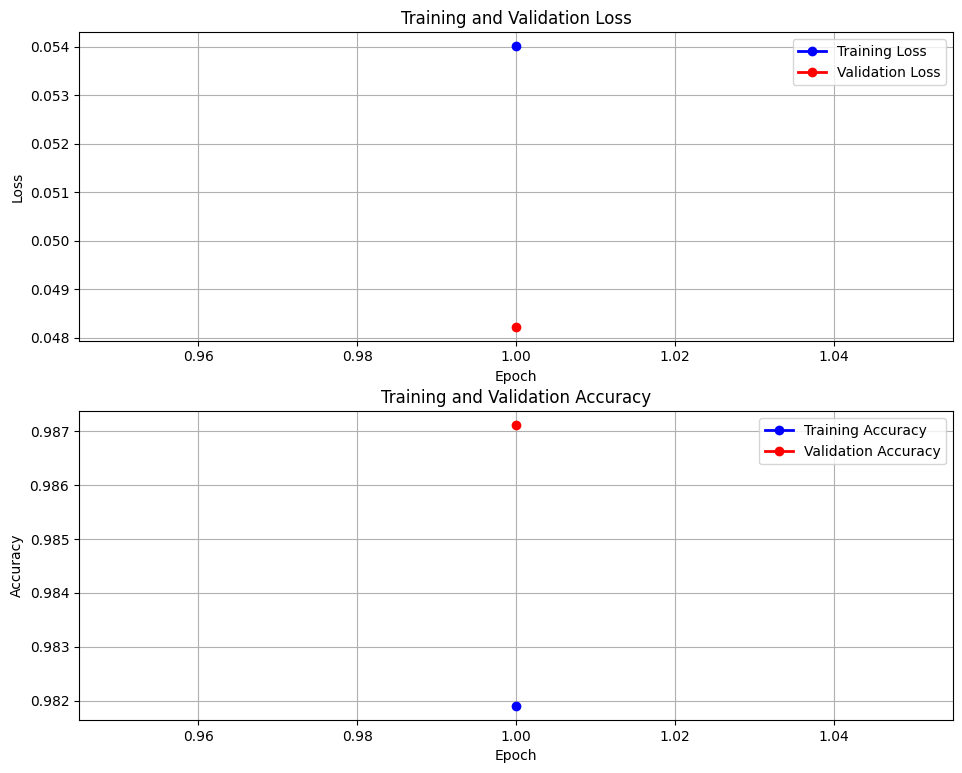

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.tight_layout(pad=3.0)

# Plot loss
ax1.plot(loss_dict['epoch'], loss_dict['train'], 'b-', marker='o', label='Training Loss', linewidth=2)
ax1.plot(loss_dict['epoch'], loss_dict['val'], 'r-', marker='o', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(accuracy_dict['epoch'], accuracy_dict['train'], 'b-', marker='o', label='Training Accuracy', linewidth=2)
ax2.plot(accuracy_dict['epoch'], accuracy_dict['val'], 'r-', marker='o', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

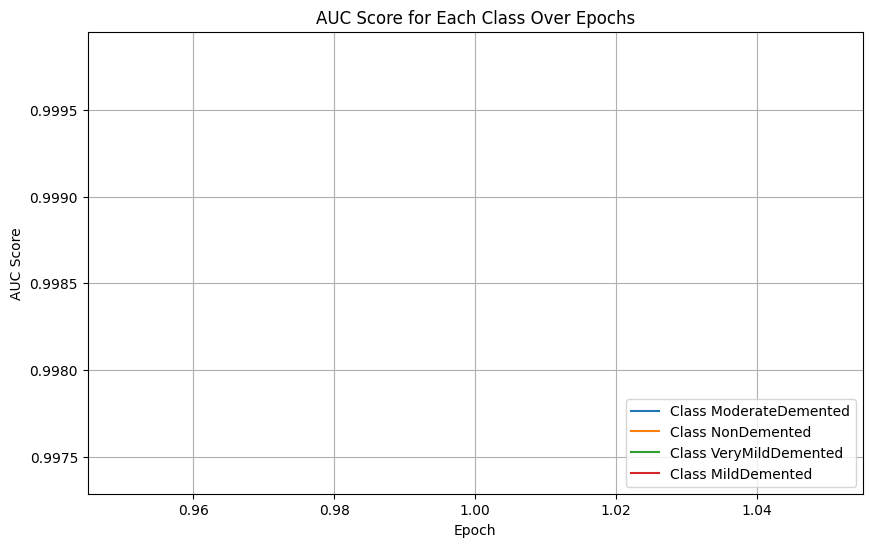

In [ ]:
# === Plot AUC for each class over epochs ===
plt.figure(figsize=(10, 6))

# Extract class names
class_names = classes

for i, class_name in enumerate(class_names):
    auc_scores_per_epoch = [epoch_scores[f'Class {class_name}'] for epoch_scores in auc_dict["auc_scores"]]
    plt.plot(auc_dict["epoch"], auc_scores_per_epoch, label=f'Class {class_name}')

plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.title('AUC Score for Each Class Over Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Initializing Test

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
with torch.no_grad():
    test_loss = 0
    total_correct = 0

    all_labels = []
    all_probs = []  # For storing predicted probabilities for ROC

    # Get the size of the test dataset
    total_test_samples = len(test_loader.dataset)

    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)
    for batch in test_loader_tqdm:
        images = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        total_correct += get_num_correct(outputs, labels)

        # Append labels and probabilities for each batch
        all_labels.extend(labels.cpu().numpy())

        # Use softmax to convert logits to probabilities
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())  # Store the probabilities for all classes

        # Update tqdm with current loss and accuracy
        test_loader_tqdm.set_postfix(
            test_loss=f"{test_loss / (test_loader_tqdm.n + 1):.3f}",
            test_accuracy=f"{(total_correct / total_test_samples):.3f}"
        )

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = total_correct / len(test_loader.dataset)

# Output the final results
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%, Total Correct: {total_correct}")

Testing: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s, test_accuracy=0.956, test_loss=0.116]

Test Loss: 0.12, Test Accuracy: 0.96%, Total Correct: 3670


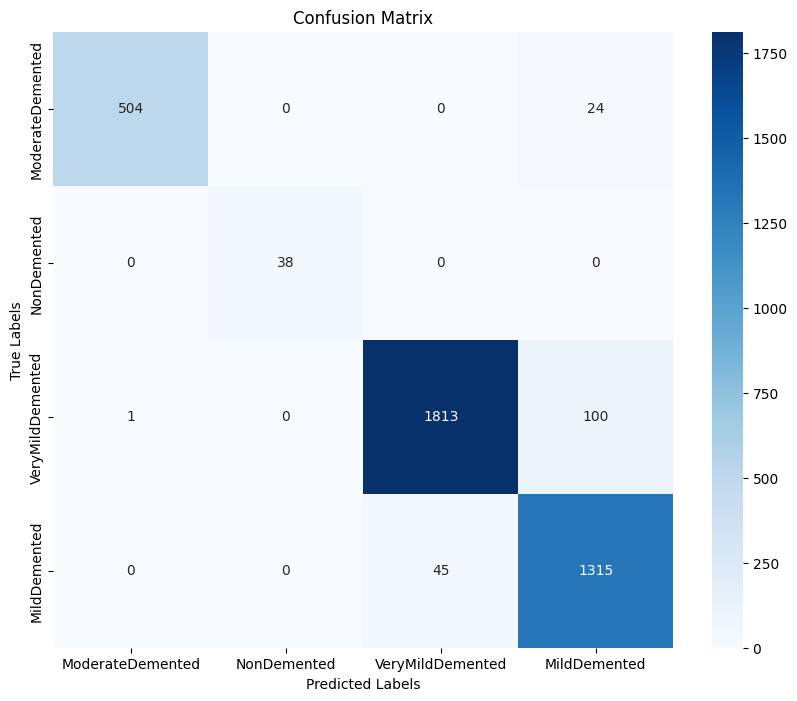

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

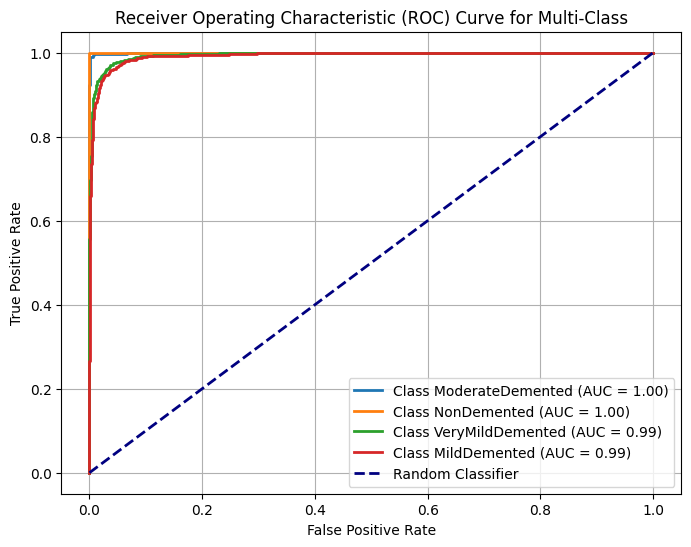

In [ ]:
n_classes = len(classes)

# Binarize the labels for multi-class ROC calculation
all_labels_one_hot = label_binarize(all_labels, classes=np.arange(n_classes))  # One-hot encode the labels
all_probs = np.array(all_probs)  # Convert list of probabilities to a numpy array

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

# Loop through each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])  # Get ROC for class i
    roc_auc = auc(fpr, tpr)  # Compute AUC for class i

    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the "chance" line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report

,precision,recall,f1-score,support
ModerateDemented,0.998020,0.954545,0.975799,528.000000
NonDemented,1.000000,1.000000,1.000000,38.000000
VeryMildDemented,0.975780,0.947231,0.961294,1914.000000
MildDemented,0.913829,0.966912,0.939621,1360.000000
accuracy,0.955729,0.955729,0.955729,0.955729
macro avg,0.971907,0.967172,0.969178,3840.000000
weighted avg,0.957137,0.955729,0.955996,3840.000000


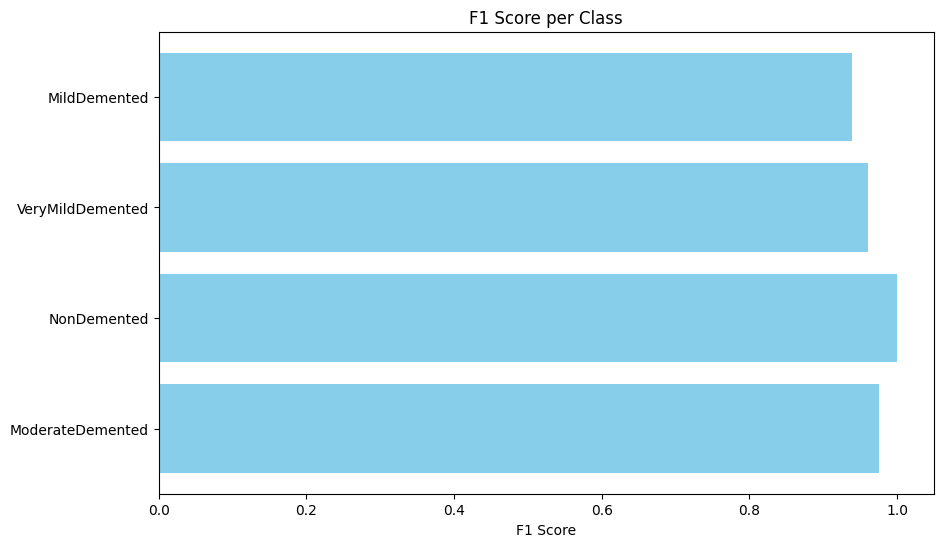

In [ ]:
# Plot the F1 scores for each class
f1_scores = df_report['f1-score'][:-3]  # Exclude the 'average' row
classes = df_report.index[:-3]  # Exclude the 'average' row

plt.figure(figsize=(10, 6))
plt.barh(classes, f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.title('F1 Score per Class')
plt.show()
